# Video Generation with TGAN
*Please note that this is an optional notebook that is meant to introduce more advanced concepts, if you're up for a challenge. So, don't worry if you don't completely follow every step! We provide external resources for extra base knowledge required to grasp some components of the advanced material.*

In this notebook, you're going to learn about TGAN, from the paper [Temporal Generative Adversarial Nets with Singular Value Clipping](https://arxiv.org/abs/1611.06624) (Saito, Matsumoto, & Saito, 2017), and its origins in image generation. Here's the quick version:

1. **Two Generators** TGAN is the first work within video generation that uses two distinct generators: a temporal generator and an image generator. The temporal generator produces temporal latent vectors $\vec{z}_t$s which were transformed by the image generator $G_i$. Works after adopt similar approaches.


2. **Created an Inception Score Benchmark** At the time, the most common quantitative comparison method was the Inception Score (IS). For a GAN trained on ImageNet, to calculate the IS one needs a pretrained Inception model. For videos, there was no comparable model to Inception, hence the authors proposed the usage of a C3D model trained on the UCF101 dataset. Using this pre-trained model they established a common method for calculating IS for video generation.


3. **Singular Value Clipping (SVC)** To enforce a 1-Lipschitz constraint on the discriminator, the authors propose clipping the singular values on the convolutional and linear layers. After every 5 epochs they perform [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) on the weight matrices and enforce the following algorithm: <br /> $\begin{gather}U \Sigma V^* = W \\ \Sigma_{ii} := \min(\Sigma_{ii}, 1) \\ W := U \Sigma V^* \end{gather}$ <br /> In their experiments they showed TGAN trained with SVC outperforms the normal GAN setup.

For this notebook, we will be focusing on the two generators. But first, some useful imports and commands:

In [1]:
%%bash

# echo Installing Library to Display gifs:
# pip install moviepy
echo Downloading pre-trained weights
# gdown https://drive.google.com/uc?id=1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I

if [ -e "/tmp/state_normal81000.ckpt" ]; then
    echo "state_normal81000.ckpt already exists!"
else
    gdown 1OFkRJqfq6RXVAN9ea7P2jveDTka5rQ3I -O /tmp/
fi

state_normal81000.ckpt already exists!


In [2]:
import torch
import torch.nn as nn
import numpy as np
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

def genSamples(g, n=8):
    '''
    Generate an n by n grid of videos, given a generator g
    '''
    with torch.no_grad():
        s = g(torch.rand((n**2, 100), device='cuda')*2 - 1).cpu().detach().numpy()

    out = np.zeros((3, 16, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n+k, :, :, :, :]

    out = out.transpose((1, 2, 3, 0))
    out = (out + 1) / 2 * 255
    out = out.astype(int)
    clip = ImageSequenceClip(list(out), fps=20)
    clip.write_gif('/tmp/sample.gif', fps=20)

## How to Generate Videos
The first thing to note about video generation is that we are now generating tensors with an added dimension. While conventional image methods work to generate tensors in $\mathbb{R}^{C \times H \times W}$, we are now generating tensors of size $\mathbb{R}^{T \times C \times H \times W}$.

To solve this problem, TGAN proposed generating temporal dynamics first, then generating images. Gordon and Parde, 2020 have a visual that summarizes the generator's process.

![generator](https://imgur.com/vH8cakL.png)

A latent vector $\vec{z}_c$ is sampled from a distribution. This vector is fed into some generic $G_t$ and it transforms the vector into a series of latent temporal vectors. $G_t:\vec{z}_c \mapsto \{\vec{z}_0, \vec{z}_1, \dots, \vec{z}_t\}$ From there each temporal vector is joined with $\vec{z}_c$ and fed into an image generator $G_i$. With all images created, our last step is to concatenate all of the images to form a video. Under this setup we decompose time and the images.

Today we will be trying to represent the UCF101 dataset. This dataset is composed of 101 action classes. Below is a sample of real examples:

![gif grid](https://imgur.com/9Cp5868.gif)

## The Temporal Generator $G_t$
Here we will be implementing our temporal generator. It transforms a vector in $\mathbb{R}^{100}$ to multiple (16 to be exact) vectors in $\mathbb{R}^{100}$. In TGAN they used a series of transposed 1D convolutions, we will discuss the limitations of this choice later.

In [3]:
class TemporalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Create a sequential model to turn one vector into 16
        self.model = nn.Sequential(
            nn.ConvTranspose1d(100, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 100, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        # initialize weights according to paper
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose1d:
            nn.init.xavier_uniform_(m.weight, gain=2**0.5)

    def forward(self, x):
        # reshape x so that it can have convolutions done
        x = x.view(-1, 100, 1)
        # apply the model and flip the
        x = self.model(x).transpose(1, 2)
        
        return x

## Putting It All Together

With our $\vec{z}_c$ generated, and our temporal vectors created, it is time to generate our individual images. The first step is to map the two vectors into appropriate sizes to be fed into a transposed 2D convolutional kernel. This is done by a linear transformation with a nonlinearity. Each newly transformed vector is reshaped to a tensor of $\mathbb{R}^{256 \times 4 \times 4}$. In this shape the two sets of vectors are concatenated across the channel dimension.

After the vectors are transformed, reshaped, and concatenated, it's finally time for us to make the images! TGAN ensues with a generic image generator of multiple transposed 2D convolutions. After enough transposed convolutions, batchnorms, and ReLUs, the final two operations are a transposed convolution to 3 color channels and a $\tanh$ activation. Our last step is to alter the shape so that the tensor has time, color-channel, height, and width dimensions. We now have a video!

In [4]:
class VideoGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # instantiate the temporal generator
        self.temp = TemporalGenerator()

        # create a transformation for the temporal vectors
        self.fast = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        # create a transformation for the content vector
        self.slow = nn.Sequential(
            nn.Linear(100, 256 * 4**2, bias=False),
            nn.BatchNorm1d(256 * 4**2),
            nn.ReLU()
        )

        # define the image generator
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # initialize weights according to the paper
        self.fast.apply(self.init_weights)
        self.slow.apply(self.init_weights)
        self.model.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-0.01, b=0.01)

    def forward(self, x):
        # pass our latent vector through the temporal generator and reshape
        z_fast = self.temp(x).contiguous()
        z_fast = z_fast.view(-1, 100)

        # transform the content and temporal vectors
        z_fast = self.fast(z_fast).view(-1, 256, 4, 4)
        z_slow = self.slow(x).view(-1, 256, 4, 4).unsqueeze(1)
        # after z_slow is transformed and expanded we can duplicate it
        z_slow = torch.cat([z_slow]*16, dim=1).view(-1, 256, 4, 4)

        # concatenate the temporal and content vectors
        z = torch.cat([z_slow, z_fast], dim=1)

        # transform into image frames
        out = self.model(z)

        return out.view(-1, 16, 3, 64, 64).transpose(1, 2)

### The Discriminator

We're no longer operating on images, so now we need to rethink our discriminator. 2D convolutions won't work due to our time dimension, what should we do? TGAN proposes a discriminator composed of a series of 3D convolutions and singular 2D convolution. From one video it produces a single integer.

```python
class VideoDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model3d = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2),
            nn.Conv3d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )

        self.conv2d = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

        # initialize weights according to paper
        self.model3d.apply(self.init_weights)
        self.init_weights(self.conv2d)

    def init_weights(self, m):
        if type(m) == nn.Conv3d or type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight, gain=2**0.5)

    def forward(self, x):
        h = self.model3d(x)
        # turn a tensor of R^NxTxCxHxW into R^NxCxHxW
        h = torch.reshape(h, (32, 512, 4, 4))
        h = self.conv2d(h)
        return h
```
Once our discriminator performs inference on some samples the generated integers are then used in the WGAN formulation (you'll learn more about this next week!):

$$\operatorname*{argmax}_D \operatorname*{argmin}_G\mathbb{E}_{x\sim \mathbb{P}_r}[D(x)]-\mathbb{E}_{z\sim p(z)}[D(G(z))]$$

During training this looks like the following.

```python
# update discriminator
pr = dis(real)
fake = gen(torch.rand((batch_size, 100), device='cuda')*2-1)
pf = dis(fake)
dis_loss = torch.mean(-pr) + torch.mean(pf)
dis_loss.backward()
disOpt.step()

# update generator
genOpt.zero_grad()
fake = gen(torch.rand((batch_size, 100), device='cuda')*2-1)
pf = dis(fake)
gen_loss = torch.mean(-pf)
gen_loss.backward()
genOpt.step()
```


This model took 16 hours to train on an RTX-2080ti, so we'll use a pretrained version to explore the results.

Note: Make sure to use a GPU runtime!

In [5]:
# instantiate the generator, load the weights, and create a sample
gen = VideoGenerator().cuda()
gen.load_state_dict(torch.load('/tmp/state_normal81000.ckpt')['model_state_dict'][0])
genSamples(gen)

MoviePy - Building file /tmp/sample.gif with imageio.


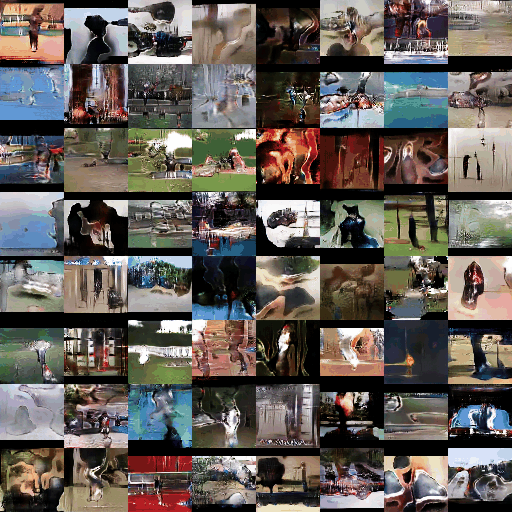

In [6]:
# Run this cell to see results!
Image(open('/tmp/sample.gif', 'rb').read())

## Where Do We Go From Here?
Your first thought is most likely that these results are less than spectacular. The subproblem of video generation is not yet anywhere near the success of StyleGAN. Suprisingly, the generated results are from the state-of-the-art model in 64 by 64 pixel video generation. As of right now, the results are unpublished, but the model holds the highest average inception score, 14.74, calculated over 10 runs of 2048 samples, with the next best being 13.62. In the original TGAN paper the model achieved 11.85. The quantitative and qualitative results open a lot of discussion within this problem. What could cause such extreme variation in training results? What is holding back video generation from reaching our qualitative standards?

One of the first limitations with this paper is that the temporal generator functions on transposed 1D convolutions. This format doesn't fully follow with how we as humans understand time. Works to follow like MoCoGAN use an LSTM, or in TGANv2 a convolutional LSTM. A pre-registered paper even proposed using neural differential equations for the temporal generator. To see how the field has progressed, here is a brief chronology:

1. VGAN, [Generating Videos with Scene Dynamics](https://arxiv.org/abs/1609.02612v3) This is the first work to propose using GANs to generate videos. In it they utilize fractionally strided 3D convolutions and argue for decomposing foreground and background. The background is static while the foreground is changing. The two are combined with a learned mask.
2. TGAN, [Temporal Generative Adversarial Nets with Singular Value Clipping](https://arxiv.org/abs/1611.06624v3) TGAN is the first work to propose decomposing temporal and image dynamics. They utilized a transposed 1D convolutions to create a series of temporal vectors and a designated image generator.
3. MoCoGAN, [MoCoGAN: Decomposing Motion and Content for Video Generation](https://arxiv.org/abs/1707.04993) Given the image generators frequent struggles with coherent individual frames, the authors proposed adding a second designated image discriminator. Under their setup they have one discriminator for the video alltogether, and one for the individual frames. Within this work it was also the first appearance of an LSTM for a temporal generator.
4. TGANv2, [Train Sparsely, Generate Densely: Memory-efficient Unsupervised Training of High-resolution Temporal GAN](https://arxiv.org/abs/1811.09245) Building off of their original success with TGAN they expand their work to generate videos of 192 by 192 pixels. They include a convolutional LSTM to generate temporal features, and residuals blocks in their discriminator and generator. In order to increase memory efficiency they also propose subsampling frames of differing resolutions to balance both temporal and per-frame quality.
5. [Latent Neural Differential Equations for Video Generation](https://arxiv.org/abs/2011.03864) In this pre-registered work, the authors take a close look at the temporal generator across many different models. They do this to explore the validity of using neural differential equations to govern temporal dynamics. The work aims to investigate using Neural Ordinary Differential Equations as well as Neural Stochastic Differential Equations to evolve each $\vec{z}_t$.

Another development has been the inclusion of Fréchet Inception Distance (FID) scores to benchmark the models. While there is not yet a perfect way to quantify GAN performance, FID has some benefits over IS. The main one is that it compares the synthetic data distribution to the real data distribution. An added bonus is that you can also use the same C3D model by selecting a certain feature layer!


Now, you've seen the primary changes, and you understand the current state-of-the-art in 64 by 64 pixel video generation, TGAN, congratulations!

## Extra Information on SVC

SVC worked well in the original TGAN paper, and its improvements have been replicated. Constraining the discriminator to a 1-Lipschitz function stabilizes training. The following graph compares the training time IS scores between TGAN trained with and without SVC.

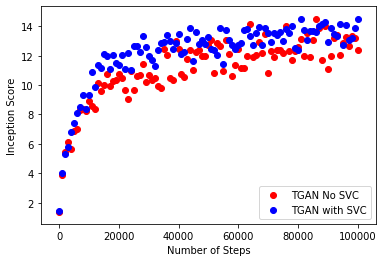

To enforce the 1-Lipschitz constraint on the discriminator, certain alterations must be made to parameters during training time. Within TGAN they give a helpful figure which explains what and how to constrain each parameter.

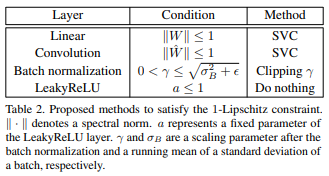

The following code/pseudocode explains how to do this within native PyTorch.

1. Define how to clip the weight matrices

```python
def singular_value_clip(w):
    dim = w.shape
    # reshape into matrix if not already MxN
    if len(dim) > 2:
        w = w.reshape(dim[0], -1)
    u, s, v = torch.svd(w, some=True)
    s[s > 1] = 1
    return (u @ torch.diag(s) @ v.t()).view(dim)
```

2. After weight updates during training, alter the layers to enforce the constraint.

```python
for iteration in range(steps):
    # update generator and discriminator weights
    # enfore 1-Lipschitz
    if iteration % 5 == 0:
        for module in list(dis.model3d.children()) + [dis.conv2d]:
            if type(module) == nn.Conv3d or type(module) == nn.Conv2d:
                module.weight.data = singular_value_clip(module.weight)
            elif type(module) == nn.BatchNorm3d:
                gamma = module.weight.data
                std = torch.sqrt(module.running_var)
                gamma[gamma > std] = std[gamma > std]
                gamma[gamma < 0.01 * std] = 0.01 * std[gamma < 0.01 * std]
                module.weight.data = gamma
```
